# Import Libraries
---

In [2]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_colwidth", 200)

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay

# Evaluation
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_predict,
    cross_validate
)
from sklearn.metrics import (
    fbeta_score,
    make_scorer,
    roc_auc_score,
    classification_report
)

import time

import pickle

---

# Methodology (Machine Learning)
---

In [5]:
df = pd.read_csv("df_clean.csv")

df["Contract"] = pd.Categorical(
    df["Contract"], categories=["Month-to-month", "One year", "Two year"]
)

df["AgeGroup"] = pd.Categorical(
    df["AgeGroup"], categories=["Under 30", "Middle Age (30–59)", "Senior (≥ 60)"]
)

df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customerID          7032 non-null   object  
 1   Partner             7032 non-null   object  
 2   MultipleLines       7032 non-null   object  
 3   InternetService     7032 non-null   object  
 4   OnlineSecurity      7032 non-null   object  
 5   OnlineBackup        7032 non-null   object  
 6   DeviceProtection    7032 non-null   object  
 7   TechSupport         7032 non-null   object  
 8   StreamingTV         7032 non-null   object  
 9   StreamingMovies     7032 non-null   object  
 10  Contract            7032 non-null   category
 11  PaperlessBilling    7032 non-null   object  
 12  PaymentMethod       7032 non-null   object  
 13  tenure              7032 non-null   int64   
 14  MonthlyCharges      7032 non-null   float64 
 15  CLTV                7032 non-null   in

## Feature Selection

In [7]:
X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

## Data Splitting

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Preprocessing

In [11]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

num_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)

cat_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_transformer, num_cols), ("cat", cat_transformer, cat_cols)],
    remainder="passthrough",
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['tenure', 'MonthlyCharges', 'CLTV',
                                  'Satisfaction Score']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Partner', 'MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod',
                                  'AgeGroup'])])

## Modeling & Evaluation

In [13]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
}

### Model Benchmarking

In [15]:
f2_scorer = make_scorer(fbeta_score, beta=2)

def benchmark_models(models: dict, X, y, cv=5):
    results = []

    for name, model in models.items():
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])

        scoring = {"f2": f2_scorer}

        try:
            scores = cross_validate(
                pipeline, X, y,
                scoring=scoring,
                cv=cv,
                return_train_score=False,
                n_jobs=-1
            )

            results.append({
                "Model": name,
                "Mean F2 Score": np.mean(scores["test_f2"]),
                "STD F2 Score": np.std(scores["test_f2"]),
                "Fit Time": np.mean(scores["fit_time"]),
                "Scoring Time": np.mean(scores["score_time"]),
            })

        except Exception as e:
            print(f"[!] Error in model '{name}': {e}")

    return pd.DataFrame(results).sort_values(by="Mean F2 Score", ascending=False)


In [16]:
benchmark_models(models, X_train, y_train)

,Model,Mean F2 Score,STD F2 Score,Fit Time,Scoring Time
0,Logistic Regression,0.886836,0.016806,0.043331,0.006512
3,Random Forest,0.876658,0.020077,0.282425,0.016261
2,Decision Tree,0.874075,0.014109,0.032394,0.006325
4,SVM,0.869862,0.019060,0.601461,0.041076
1,KNN,0.859888,0.021039,0.025565,0.042910


### Tuning Hyperparameter

In [18]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(
    pipe,
    param_grid,
    scoring=f2_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values(by='mean_test_score', ascending=False)
cv_results[['params', 'mean_test_score', 'std_test_score']]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,params,mean_test_score,std_test_score
17,"{'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}",0.890026,0.015194
16,"{'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}",0.890025,0.015705
18,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}",0.889587,0.015894
19,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}",0.889029,0.016005
12,"{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}",0.888168,0.015976
13,"{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}",0.888085,0.015877
14,"{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}",0.886472,0.016567
15,"{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}",0.886279,0.016532
8,"{'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}",0.874603,0.022325
11,"{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}",0.872499,0.019376


F2 Score on Test Set: 0.8780487804878049
Classification Report:


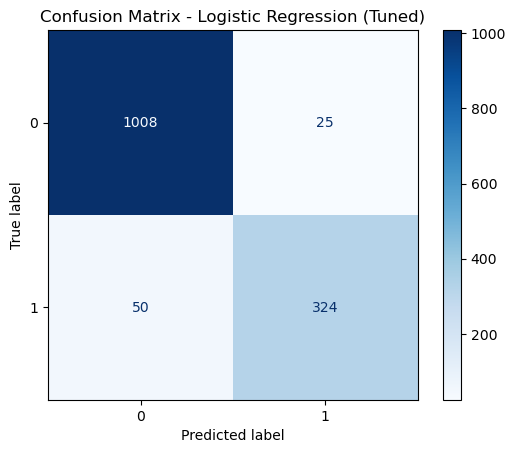

In [19]:
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        C=10,
        penalty='l1',
        solver='saga',
        max_iter=1000
    ))
])

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(f"F2 Score on Test Set: {f2}")
print("Classification Report:")

ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Tuned)")
plt.grid(False)
plt.show()

### Feature Importance

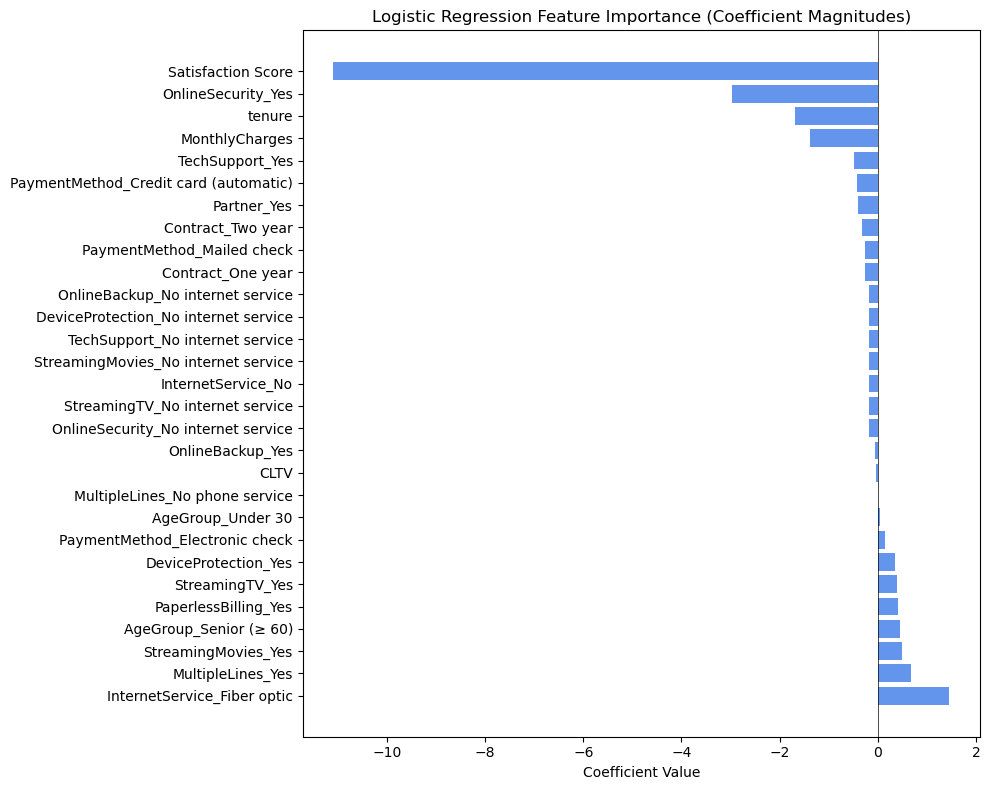

In [44]:
ohe = final_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
ohe_features = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, ohe_features])

coeffs = final_model.named_steps["classifier"].coef_.flatten()

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coeffs
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="cornflowerblue")
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Logistic Regression Feature Importance (Coefficient Magnitudes)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

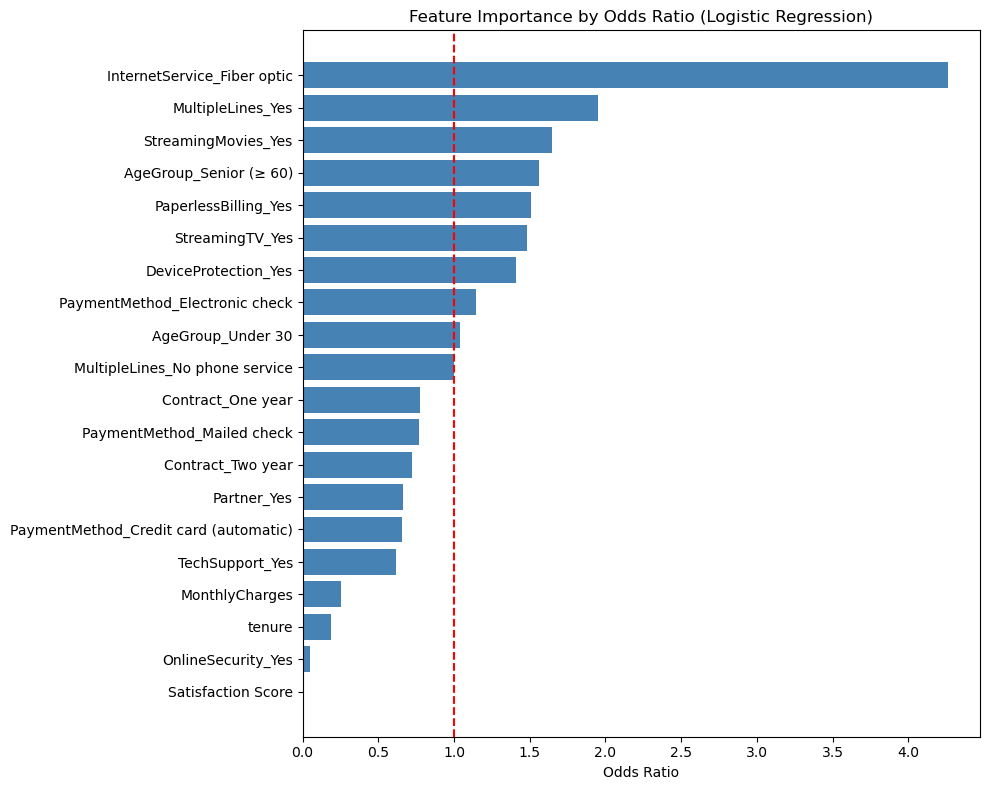

In [54]:
all_features = np.concatenate([num_cols, ohe_features])
odds_ratios = np.exp(coeffs)

odds_df = pd.DataFrame({
    "Feature": all_features,
    "Odds Ratio": odds_ratios,
    "Coefficient": coeffs
}).sort_values(by="Odds Ratio", ascending=True)

plt.figure(figsize=(10, 8))
top_bottom = pd.concat([odds_df.head(10), odds_df.tail(10)])

plt.barh(top_bottom["Feature"], top_bottom["Odds Ratio"], color="steelblue")
plt.axvline(1.0, linestyle='--', color='red')
plt.xlabel("Odds Ratio")
plt.title("Feature Importance by Odds Ratio (Logistic Regression)")
plt.tight_layout()
plt.show()

### Save Model

In [24]:
pickle.dump(final_model, open("model.pkl", "wb"))